In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

from utils import angle_to_rgb, get_colored_difference_image
from gui_config import RunConfiguration
from gui_utils import load_and_preprocess_feature_map, get_padded_moving_and_static, run_config
from bcpd_wrapper import run_bayesian_coherent_point_drift as run_bcpd

from gradient_directions import get_main_gradient_angles_and_intervals, plot_binary_assignments, plot_gradients_as_arrows
from distance_transform import get_binary_assignments_from_gabor

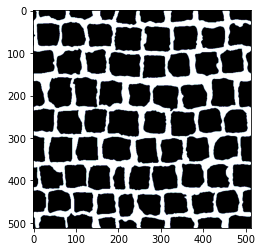

In [23]:
config = RunConfiguration(
    feature_map_path="cobblestone_floor_03.png",
    downscale_factor=2,
    patch_position=250,
    filter_method="gabor",
    gabor_filter_sigma=0.5,
    response_cutoff_threshold=0.5,
    centroid_method="histogram clustering",
    kde_rho=0.8,
    assignment_type="binary",
    reduce_boundary_weights=True,
    transform_type="dense",
    rbf_type="linear",
    smoothness=3000,
    num_iterations=30,
    num_dct_coeffs=100
)

feature_map = load_and_preprocess_feature_map(Path("data/feature_maps") / config.feature_map_path, config.downscale_factor)
plt.imshow(feature_map, cmap="bone")

In [24]:
result_obj = run_config(config, tqdm(total=config.num_iterations))

C:\Users\leifv\Uni\cglab\gui_utils.py:138: UserWarning: No explicit patch slices are given. run_config will use find_promising_patch_pairs with the currently configured patch size, stride and padding size, which is slow and may lead to inconsistent results. Consider passing a config with explicit values for 'moving_slices' and 'static_slices'.
  warnings.warn("No explicit patch slices are given. run_config will use "
 74%|██████████████████████████████████████████████████████▉                   | 14196/19110 [00:01<00:00, 8653.74it/s]
C:\Users\leifv\Uni\cglab\gui_utils.py:210: UserWarning: The config and results will not be saved as a file, because 'file_path' is None.
  config.save_results(results_obj)


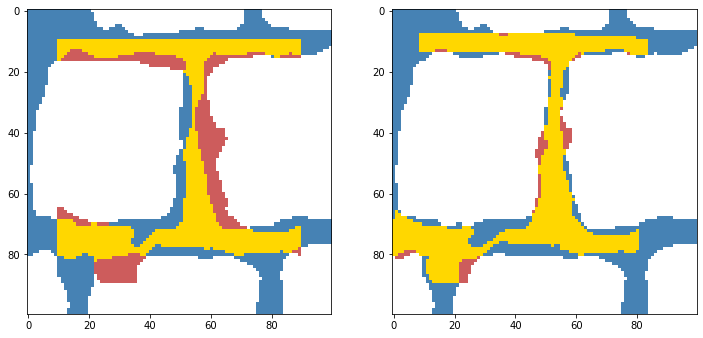

In [25]:
_, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(get_colored_difference_image(moving=result_obj.moving, static=result_obj.static))
axs[1].imshow(get_colored_difference_image(moving=result_obj.warped_moving[-1], static=result_obj.static))

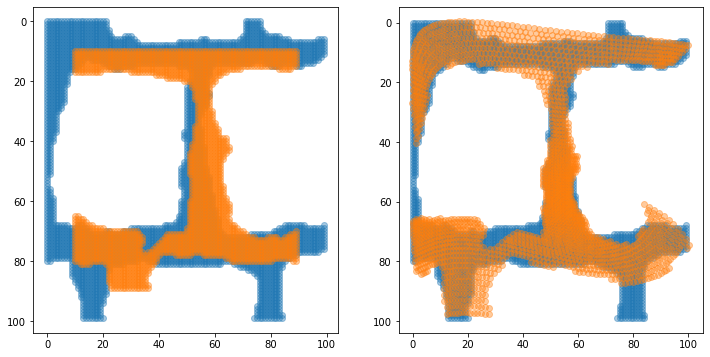

In [28]:
moving_points = np.argwhere(result_obj.moving)
static_points = np.argwhere(result_obj.static)

y = run_bcpd(static_points, moving_points, A=True)

_, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[0].scatter(moving_points[:,1], moving_points[:,0], alpha=0.4)
axs[0].invert_yaxis()

axs[1].scatter(static_points[:,1], static_points[:,0], alpha=0.4)
axs[1].scatter(y[:,1], y[:,0], alpha=0.4)
axs[1].invert_yaxis()

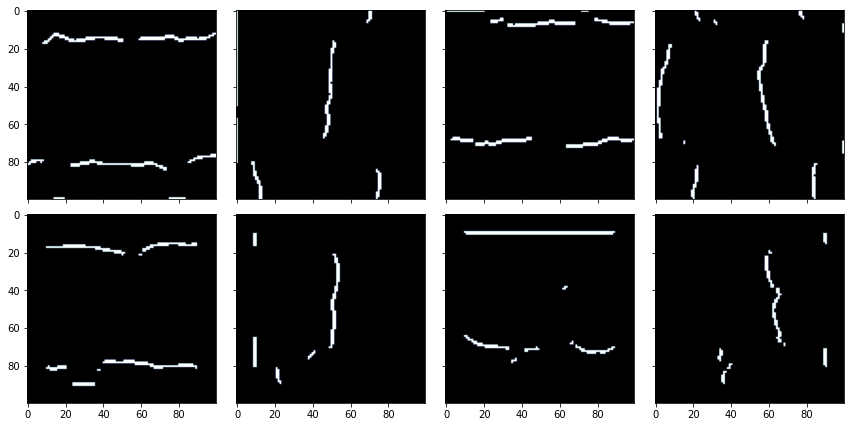

In [34]:
centroids, intervals = get_main_gradient_angles_and_intervals(result_obj.static, rho=config.kde_rho)
static_assignments = get_binary_assignments_from_gabor(result_obj.static, centroids, intervals,
                                                       sigma=config.gabor_filter_sigma,
                                                       threshold=config.response_cutoff_threshold)
moving_assignments = get_binary_assignments_from_gabor(result_obj.moving, centroids, intervals,
                                                       sigma=config.gabor_filter_sigma,
                                                       threshold=config.response_cutoff_threshold)

_, axs = plt.subplots(2,4,figsize=(12,6), sharex=True, sharey=True)

for i, (st_assignment, mv_assignment) in enumerate(zip(static_assignments, moving_assignments)):
    axs[0,i].imshow(st_assignment, cmap='bone')
    axs[1,i].imshow(mv_assignment, cmap='bone')
    
plt.tight_layout()